In [1]:
sample = "5FU_FO837"
#template = "cCARLIN"
data_path = "/home/zhoujiaqi/data/zhoujiaqi/CARLIN/Processed/amplicon/fastq/"
output_dir = "/home/zhoujiaqi/data/zhoujiaqi/CARLIN/code/output/"
ref_dir ='/home/zhoujiaqi/data/zhoujiaqi/CARLIN/Analysis/5FU/FO837/SC/Transcriptome/filtered_barcodes_umi_mt.txt'
#CARLIN_read_cutoff=3 # used to compare with CARLIN pipeline
cfg="sc10xV3" # ['sc10xV3',  'scCamellia']
coarse_grained_readcutoff_floor=5 # the lower bound of the later read count filtering, after denoising, and re-group reads. 
distance_relative_threshold=0.03 # 5% error rate, will be multipled with the sequence length
read_ratio_threshold=0.6
#seq_3prime_upper_N=15
#seq_5prime_upper_N=None

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
from mosaiclineage import DARLIN as car
from mosaiclineage import larry

/home/zhoujiaqi/miniconda2/envs/darlin/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [3]:
import importlib
importlib.reload(car)
importlib.reload(larry)
#%config InlineBackend.figure_format = 'svg' #'retina'         # or 'svg'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',100)
%matplotlib inline

# Single-cell CARLIN pipeline for 10x data

In [4]:
ref_name=cfg
df_ref_BC=pd.read_csv(f'{ref_dir}',
                      sep='\t',header=None,names=['CB'])

In [5]:
df_ref_BC

,CB
0,AAACCTGAGGTGTTAA
1,AAACCTGCAAAGCGGT
2,AAACCTGCACGAAATA
3,AAACCTGCACTGAAGG
4,AAACCTGCACTGTTAG
...,...
3120,TTTGGTTTCTGGGCCA
3121,TTTGTCAAGCAAATCA
3122,TTTGTCATCACGATGT
3123,TTTGTCATCAGTTGAC


In [6]:
%%time
## load sequences
df_raw_reads=car.CARLIN_raw_reads(data_path+sample,sample,protocol=cfg)

CPU times: user 5min 35s, sys: 7.15 s, total: 5min 43s
Wall time: 5min 42s


In [7]:
df_raw_reads

,cell_bc,cell_bc_quality_mean,cell_bc_quality_min,library,cell_id,umi,umi_quality_mean,umi_quality_min,umi_id,clone_id,clone_id_quality_mean,clone_id_quality_min
0,GTCGGGTTCCTAGGGC,35.0625,32,5FU_FO837,5FU_FO837_GTCGGGTTCCTAGGGC,GAGAAGTACG,37.7,36,GTCGGGTTCCTAGGGC_GAGAAGTACG,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,31.297143,12
1,AGCTCTCCATTGGCGC,36.1250,33,5FU_FO837,5FU_FO837_AGCTCTCCATTGGCGC,CCTGCACACG,38.2,38,AGCTCTCCATTGGCGC_CCTGCACACG,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,33.402857,12
2,CTTCTCTTCAACACCA,34.6250,18,5FU_FO837,5FU_FO837_CTTCTCTTCAACACCA,TGTCTAGGCT,33.4,19,CTTCTCTTCAACACCA_TGTCTAGGCT,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,29.525714,12
3,CCCAATCGTGCTTCTC,29.1875,16,5FU_FO837,5FU_FO837_CCCAATCGTGCTTCTC,CCCAACCTTT,36.8,30,CCCAATCGTGCTTCTC_CCCAACCTTT,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,27.771429,12
4,AAGGCAGCATTATCTC,35.4375,33,5FU_FO837,5FU_FO837_AAGGCAGCATTATCTC,GTAACTTTGG,38.3,38,AAGGCAGCATTATCTC_GTAACTTTGG,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,31.340000,12
...,...,...,...,...,...,...,...,...,...,...,...,...
2747735,TGGGCGTGTCGACTAT,33.5625,30,5FU_FO837,5FU_FO837_TGGGCGTGTCGACTAT,TTTGCAGATG,36.5,33,TGGGCGTGTCGACTAT_TTTGCAGATG,GAGCTGTACAAGTAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,3.662857,2
2747736,CCTACACTCAGCGATT,35.3750,30,5FU_FO837,5FU_FO837_CCTACACTCAGCGATT,CATTGGGATG,38.3,38,CCTACACTCAGCGATT_CATTGGGATG,GAGCTGTACAAGTAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,3.791429,2
2747737,CGATGTAAGGTGTGGT,29.2500,16,5FU_FO837,5FU_FO837_CGATGTAAGGTGTGGT,CGGACAACGA,31.0,15,CGATGTAAGGTGTGGT_CGGACAACGA,GAGCTGTACAAGTAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,3.488571,2
2747738,TATCAGGAGAAGGTGA,31.7500,16,5FU_FO837,5FU_FO837_TATCAGGAGAAGGTGA,CAGTAGCGCA,37.7,34,TATCAGGAGAAGGTGA_CAGTAGCGCA,GAGCTGTACAAGTAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,3.354286,2


In [8]:
df_N=df_raw_reads[df_raw_reads['cell_bc'].apply(lambda x: 'N' in x)]
print('N fraction:',len(df_N)/len(df_raw_reads))

N fraction: 4.4400125193795626e-05


In [9]:
%%time
df_filter_reads=car.CARLIN_preprocessing(df_raw_reads,ref_cell_barcodes=df_ref_BC['CB'])

Fastq with valid barcodes: 2117272
CPU times: user 25.6 s, sys: 489 ms, total: 26 s
Wall time: 26 s


In [10]:
df_filter_reads

,cell_bc,library,cell_id,umi,umi_id,clone_id,read
0,GTCGGGTTCCTAGGGC,5FU_FO837,5FU_FO837_GTCGGGTTCCTAGGGC,GAGAAGTACG,GTCGGGTTCCTAGGGC_GAGAAGTACG,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,1
1,AGCTCTCCATTGGCGC,5FU_FO837,5FU_FO837_AGCTCTCCATTGGCGC,CCTGCACACG,AGCTCTCCATTGGCGC_CCTGCACACG,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,1
2,CTTCTCTTCAACACCA,5FU_FO837,5FU_FO837_CTTCTCTTCAACACCA,TGTCTAGGCT,CTTCTCTTCAACACCA_TGTCTAGGCT,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,1
3,CCCAATCGTGCTTCTC,5FU_FO837,5FU_FO837_CCCAATCGTGCTTCTC,CCCAACCTTT,CCCAATCGTGCTTCTC_CCCAACCTTT,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,1
4,AAGGCAGCATTATCTC,5FU_FO837,5FU_FO837_AAGGCAGCATTATCTC,GTAACTTTGG,AAGGCAGCATTATCTC_GTAACTTTGG,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,1
...,...,...,...,...,...,...,...
2117267,TGGGCGTGTCGACTAT,5FU_FO837,5FU_FO837_TGGGCGTGTCGACTAT,TTTGCAGATG,TGGGCGTGTCGACTAT_TTTGCAGATG,GAGCTGTACAAGTAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,1
2117268,CCTACACTCAGCGATT,5FU_FO837,5FU_FO837_CCTACACTCAGCGATT,CATTGGGATG,CCTACACTCAGCGATT_CATTGGGATG,GAGCTGTACAAGTAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,1
2117269,CGATGTAAGGTGTGGT,5FU_FO837,5FU_FO837_CGATGTAAGGTGTGGT,CGGACAACGA,CGATGTAAGGTGTGGT_CGGACAACGA,GAGCTGTACAAGTAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,1
2117270,TATCAGGAGAAGGTGA,5FU_FO837,5FU_FO837_TATCAGGAGAAGGTGA,CAGTAGCGCA,TATCAGGAGAAGGTGA_CAGTAGCGCA,GAGCTGTACAAGTAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,1


## Check raw data qualities

Check raw data to decide the read cutoff. If we see a linear slope between read number per cell and clone number per cell, this is a signature of sequencing-error induced clonal diversity

Identified 1457 putative cell_id


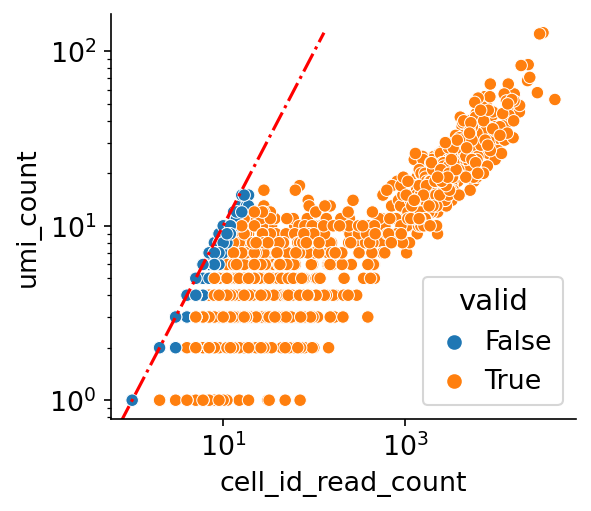

In [11]:
df_valid_cells=larry.extract_putative_valid_cell_id(df_filter_reads,signal_threshold=1.5,cell_key="cell_id",)

In [12]:
df_valid_cells

,cell_id,cell_id_read_count,umi_count,valid
0,5FU_FO837_AAACCTGAGGTGTTAA,5,3,True
8,5FU_FO837_AAACGGGGTAATTGGA,2618,17,True
10,5FU_FO837_AAACGGGTCGCCGTGA,456,6,True
11,5FU_FO837_AAAGATGAGGACAGCT,21,7,True
12,5FU_FO837_AAAGATGCACAGCCCA,4,2,True
...,...,...,...,...
2958,5FU_FO837_TTTGCGCGTTCTCATT,9,4,True
2959,5FU_FO837_TTTGCGCTCATCTGTT,4,1,True
2960,5FU_FO837_TTTGGTTCAAGCTGGA,73,5,True
2961,5FU_FO837_TTTGGTTCAATCGAAA,5,3,True


In [13]:
df = pd.DataFrame(df_valid_cells)
df.to_csv(output_dir+sample+'.csv', index=False)

We are interested to see at what read cutoff the corresponding cell number or clone number conform to our expectation. 

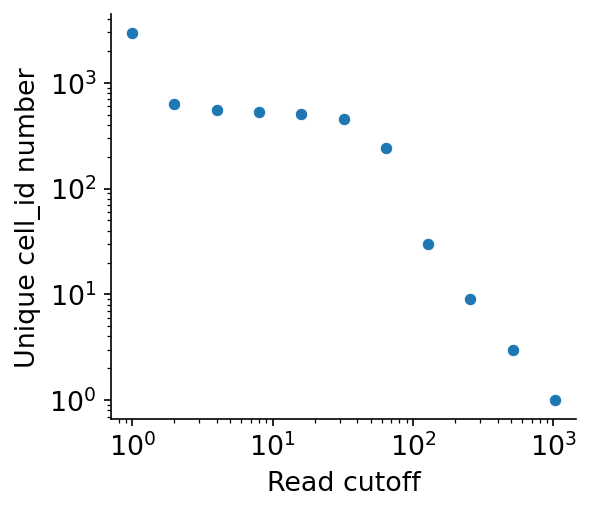

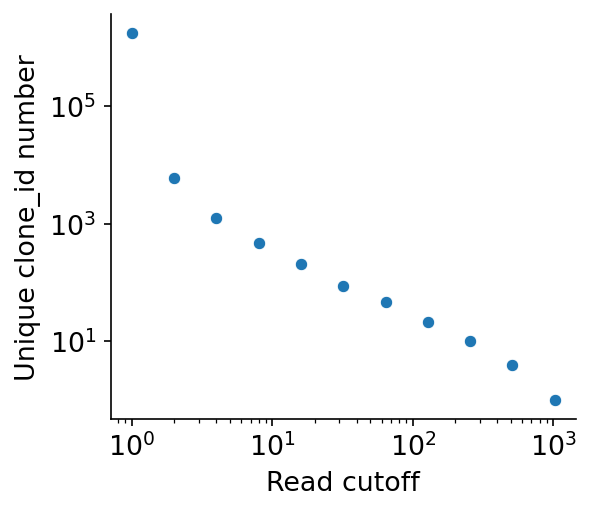

In [14]:
df_unique=larry.QC_unique_cells(df_filter_reads,target_keys=['cell_id','clone_id'])

In [15]:
larry.print_statistics(df_filter_reads)

library number: 1
cell_id number: 2968
clone_id number: 1776589
umi_id number: 21832
total reads: 2117K


## Collapse clone_id and filter cells within the same clone_id length

We first perform barcode cleaning within a certian distance, then re-calculate the read number, and filter out low-read-count sequences. The read threshold is determined as the 10% of the max read count within each sequence length group, with a lower bound at coarse_grained_readcutoff_floor

In [16]:
df_filter_reads['bc_length']=df_filter_reads['clone_id'].apply(lambda x: len(x))
read_cutoff=2 # initial read count filtering 
# coarse_grained_readcutoff_floor=5 # the lower bound of the later read count filtering, after denoising, and re-group reads. 
# distance_relative_threshold=0.05 # 5% error rate, will be multipled with the sequence length
    
# use a low-filtering threshold, and also avoid filtering out valid_cell ids from above
def filter_low_read_cells(df,coarse_grained_readcutoff=None):
    if coarse_grained_readcutoff is None:
        coarse_grained_readcutoff=np.max([coarse_grained_readcutoff_floor,0.01*df['read'].max()])
    return df[(df['read']>=coarse_grained_readcutoff) | df['cell_id'].isin(df_valid_cells['cell_id'].unique())]

df_list=[]
unique_seq_length=list(set(df_filter_reads['bc_length']))
for target_length in sorted(unique_seq_length):
    df_tmp=df_filter_reads[df_filter_reads['bc_length']==target_length]#.groupby(['cell_bc','clone_id']).agg({'read':'sum'})
    df_HQ=larry.denoise_clonal_data(df_tmp,
        target_key="clone_id",
        denoise_method="UMI_tools",  # UMI_tools, 'Hamming'
        distance_threshold=1, #np.max([1,int(target_length*distance_relative_threshold)]),      
        read_cutoff=read_cutoff,
        whiteList=None,
        plot_report=False,
        progress_bar=False)

    df_HQ_group=larry.group_cells(df_HQ,group_keys=["library","cell_id","cell_bc","clone_id"])
    df_out=df_HQ_group.groupby('clone_id',group_keys=True).apply(filter_low_read_cells).reset_index(drop=True)
    df_out['bc_length']=target_length
    df_list.append(df_out)
df_denoise_bc_1=pd.concat(df_list)

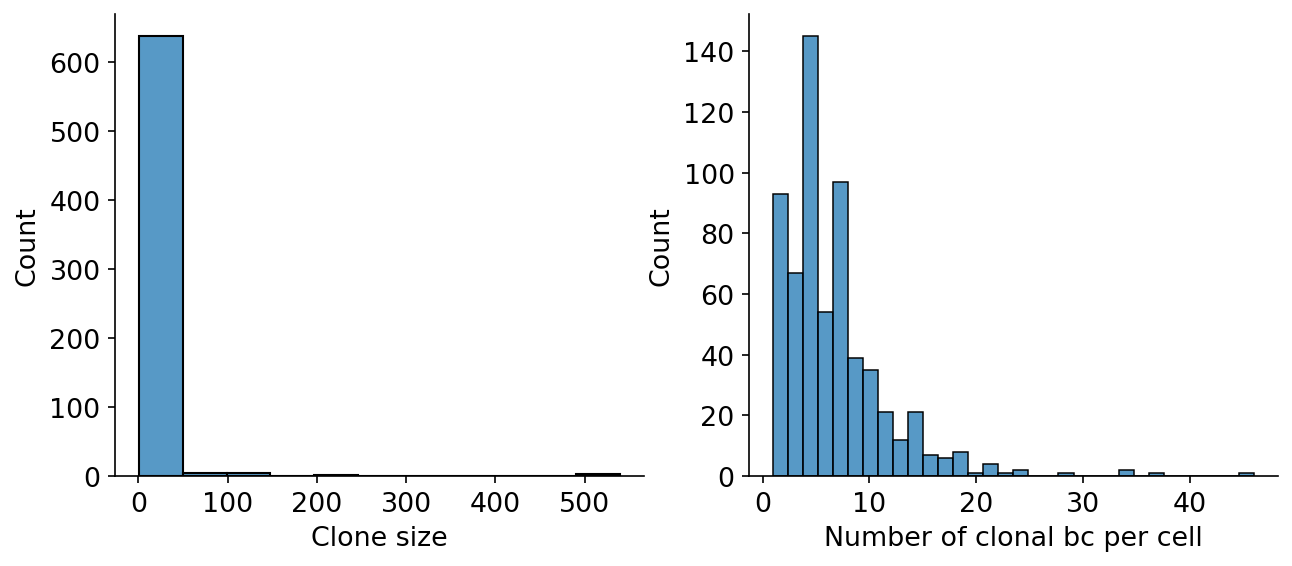

In [17]:
larry.QC_clonal_reports(df_denoise_bc_1)

## Select dominant clone_id within each cell_id

The above operation leaves some cell barcodes to have multiple clone barcodes. We select the read-dominant clonal barcodes as the putative clone id for each cell barcode.

seq length


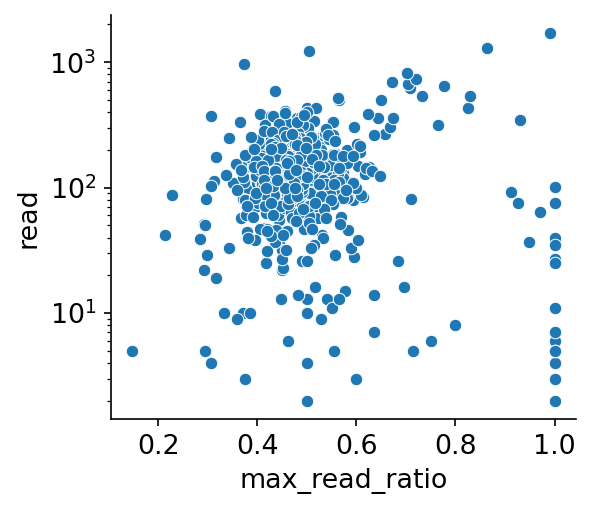

In [18]:
# select dominant barcode sequence within each cell barcode, we use a very high read_ratio to avoid false positive
#df_dominant_frac=car.calculate_read_fraction_for_dominant_sequences(df_denoise_bc_2,cell_bc_key='cell_bc',clone_key='clone_id')
df_dominant=larry.obtain_read_dominant_sequences(df_denoise_bc_1,cell_bc_key='cell_bc',clone_key='clone_id')
sns.scatterplot(data=df_dominant,x='max_read_ratio',y='read')
plt.yscale('log')